In [11]:
import os
import glob
import re
import sys

# from gridded_data_visualize import load_velocity_data
from datetime import datetime
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString
import rasterstats
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections.abc import Iterable
from sklearn import linear_model
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.ticker import LogFormatter, FixedLocator
import rasterio

                 0          63         126        189        252        315   \
2014-06-06  23.188058  19.683348  29.634529  52.206068  66.994006  76.221120   
2014-07-26        NaN        NaN        NaN        NaN        NaN        NaN   
2014-09-14        NaN        NaN        NaN        NaN        NaN        NaN   
2014-09-23  33.743860  16.248812  16.891879  44.671144  51.789774  67.358895   
2014-11-03        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2021-06-19  24.599753  18.419449  17.045802  16.241075  17.704509  54.195566   
2021-07-19        NaN        NaN        NaN        NaN        NaN        NaN   
2021-07-20  22.675900  19.588973  18.505341  18.190063  19.718074  53.608614   
2021-09-07        NaN        NaN        NaN        NaN        NaN        NaN   
2021-10-05  22.852641   8.684505   7.487359   7.044186   7.260527  41.111199   

                 378        441        

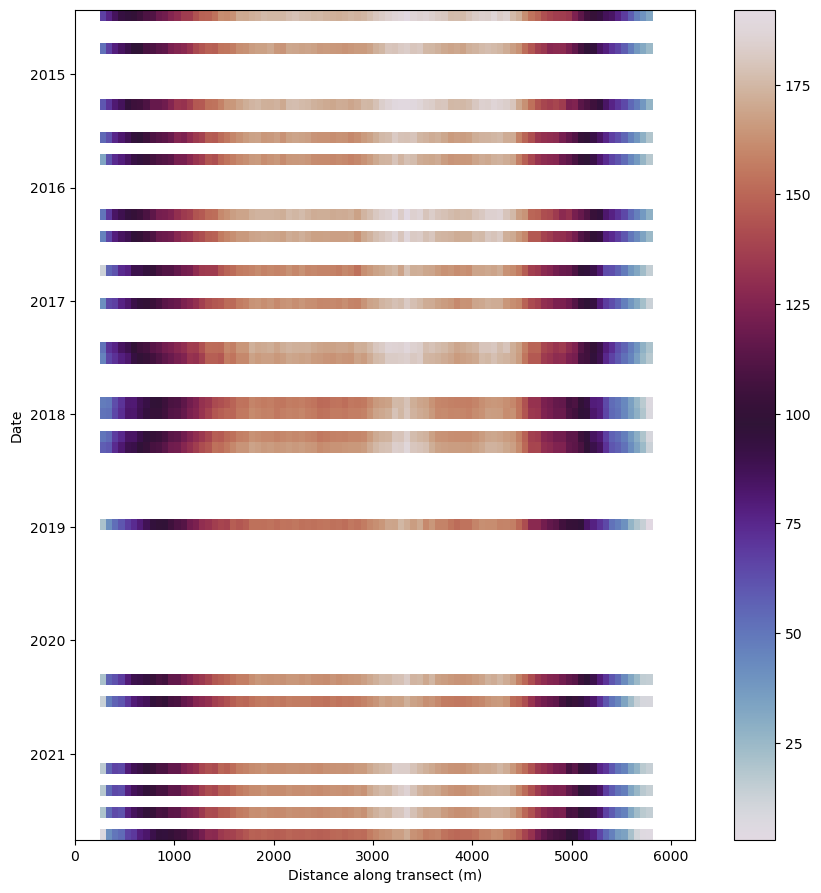

In [44]:
def load_transect(transect_path):

    transect = gpd.read_file(transect_path)
    L = transect.length[0]  # grab transect length (assuming single geometry)
    n = 100
    transect_points = [transect.geometry[0].interpolate(x) for x in np.linspace(0, L, n)]  # get points along your transect
    transect_points = pd.DataFrame(transect_points)
    transect_points.columns = ['geometry']
    transect_points = gpd.GeoDataFrame(transect_points, geometry='geometry', crs='EPSG:32608')
    x = transect_points['geometry'].x
    y = transect_points['geometry'].y
    transect_linestring = LineString(list(zip(x, y)))
    distances = np.insert(np.array(np.cumsum([np.round(np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2)) for i in range(1, len(x))]), dtype=int), 0, 0)
    return transect_linestring, distances, x, y


def load_vel_radarstats(directory, cross_transect):
   
    # Initialize an empty DataFrame
    df = pd.DataFrame()

    # Iterate over the subdirectories
        # Find all files that end with 'vv_v04.0_utm.tif'
    for i, filepath in enumerate(glob.glob(f'{directory}/*.tif')):
        filename = os.path.basename(filepath)
        # with rasterio.open(filepath) as dataset:
        #     print(dataset.meta)
        # Extract the date string from the filename
        # date_str = filename.split('_')[1].split('.')[0]
        date_str = extract_date_from_filename(filename)

        # Convert the date string to a datetime object
        formatted_date = datetime.strptime(date_str, "%Y%m%d")
        transect_linestring, distances, x, y = load_transect(cross_transect)
        vel = rasterstats.point_query(transect_linestring, filepath)[0]
        # Flatten the list of lists
        vel_flat = [v[0] if isinstance(v, list) else v for v in vel]

        # Create a DataFrame for the current date and velocities
        temp_df = pd.DataFrame(vel_flat, index=distances, columns=[formatted_date])
        # Append the data to the main DataFrame
        # print(x)
        df = pd.concat([df, temp_df], axis=1)
    # Transpose the DataFrame to have dates as the index and distances as columns
    df = df.T
    df.index = pd.to_datetime(df.index)

   
    return df, x, y

def add_missing_dates(df, start_date, end_date, time_filter):
    # If time_filter is 'none', return the DataFrame as is
    if time_filter == 'none':
        return df

    # Create a date range with the specified frequency
    date_range = pd.date_range(start=start_date, end=end_date, freq=time_filter)
    # Create a list to hold the DataFrame and any new rows
    df_list = [df]
    
    # Iterate through the date range and add missing dates
    for date in date_range:
        if date not in df.index:
            # Create an empty array (or a row of NaNs) with the same columns as the DataFrame
            empty_row = pd.Series([np.nan] * df.shape[1], index=df.columns, name=date)
            # Append the empty row to the list
            df_list.append(empty_row.to_frame().T)
    
    # Concatenate the original DataFrame with the new rows
    df = pd.concat(df_list)
    
    # Sort the DataFrame by index to maintain chronological order
    df = df.sort_index()
    
    return df

def plot_heatmap(df, cross_transect):
    df.index = pd.to_datetime(df.index)
    
    # #grab original start and end dates to add missing data at correct frequency (ex 12D for Sentinel1)
    start_date_first = df.index.min()
    end_date_first = df.index.max()
    
    df = add_missing_dates(df, start_date_first, end_date_first, '50D')
    print(df)
    #filter out outside distances with nans
    df = filter_distances(cross_transect, df)

    # arrange in correct form for imshow
    y = np.unique(df.index)#time
    x = np.unique(df.columns.astype(float))#distance
    X, Y = np.meshgrid(x, y)
    Z = df.values.reshape(len(x), len(y))
    data = Z # 




    #create plot
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(figsize=(10, 10))

    cax = ax.imshow(df, aspect='auto', cmap='twilight', extent=(np.amin(X), np.amax(X), np.amax(Y), np.amin(Y)))
     
    # # Set y-ticks and labels for January, March, June, and October
    # ax.yaxis.set_major_locator(mspecs[0])
    # ax.yaxis.set_major_formatter(mspecs[1])
    ax.set_xlabel('Distance along transect (m)')
    ax.set_ylabel('Date')
    # ax.set_facecolor('grey')
    # Set y-limits based on start_date and end_date
    # ax.set_ylim(pd.to_datetime(end_date), pd.to_datetime(start_date))
    # ax.set_xticklabels([''] * len(ax.get_xticks()))

    #grab title from filename 
    filename = cross_transect.split('/')[-1]
    filename = filename.split('.')[0]
    filename = re.sub(r'(\d+)', r' \1', filename.capitalize().replace('transect', 'Transect'))

    # ax.set_title(f'{filename}')

    #create colorbar
    cbar = plt.colorbar(cax, location='right')
    # cbar.set_label(title)
    plt.subplots_adjust(top=0.99, bottom=0.16)  # Adjust top and bottom to reduce vertical space
    # Adjust hspace to reduce vertical space

    plt.show()

    # # Save or show the plot
    # if viz == 'save' and start_date is None:
    #     plt.savefig(f'{save_folder}{veltype_plot}_heatmap.png')
    # elif viz == 'save' and start_date is not None:
    #     start_date = start_date.strftime('%Y-%m-%d')
    #     end_date = end_date.strftime('%Y-%m-%d')
    #     plt.savefig(f'{save_folder}{veltype_plot}_heatmap_{start_date}_{end_date}.png')
    # elif viz == 'show':
    #     plt.show()
    # plt.close(fig)  # Close the figure
    return

def extract_date_from_filename(filename):
    # Use regular expression to find the date in the format YYYYMMDD
    match = re.search(r'\d{8}', filename)
    if match:
        return match.group(0)
    else:
        raise ValueError("No date found in the filename")


def filter_distances(cross_transect, df):
    # Define distance thresholds for each transect
    transect_thresholds = {
        'transect1.shp': (730, 3760),
        'transect2.shp': (635, 5015),
        'transect4.shp': (235, 5820)
    }


    # Get the filename from the path
    filename = cross_transect.split('/')[-1]

    # Check if the filename is in the thresholds dictionary
    if filename in transect_thresholds:
        min_threshold, max_threshold = transect_thresholds[filename]

        # Apply the filtering
        for i, distance in enumerate(df.columns.astype(float)):
            if distance < min_threshold or distance > max_threshold:
                df.iloc[:, i] = np.nan

    # If the filename is 'transect4.shp', do nothing
    elif filename == 'transect3.shp':
        print("No filtering applied for transect3.shp")

    return df

if __name__ == '__main__':
 
    input_directory = '/home/lynn/VS_Code/DEM_transect/data/01_utm_arcticdem/'
    transect_name = '/home/lynn/VS_Code/DEM_transect/data/transect4.shp'

    df, x, y= load_vel_radarstats(input_directory, transect_name)
    plot_heatmap(df, transect_name)
